#### **CCA 上位n%区分によるポートフォリオの作成と、等ポートフォリオとのリターン比較**

In [71]:
from helpers import *

In [72]:
df = pd.read_csv('../../DATAHUB/aba922ff-cef0-4bc7-8899-00fc08a14023.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df

,DATE,TICKER,TOTAL_SALES
0,2013-01-01,2138,985151
1,2013-02-01,2138,1177610
2,2013-03-01,2138,1852193
3,2013-04-01,2138,1595681
4,2013-05-01,2138,1997601
...,...,...,...
38970,2025-02-01,u_YDBS,1233451190
38971,2025-03-01,u_YDBS,1447258480
38972,2025-04-01,u_YDBS,1258859842
38973,2025-05-01,u_YDBS,1199917267


In [73]:
# データ読み込みとフィルタリング
df_filtered = filter_data_cca(df, start_date='2021-07-01', end_date='2024-07-01')
df_filtered

original data: 38975
filtered data: 8806


,DATE,TICKER,TOTAL_SALES
102,2021-07-01,2138,32266157
103,2021-08-01,2138,24980029
104,2021-09-01,2138,20952340
105,2021-10-01,2138,29118257
106,2021-11-01,2138,31297829
...,...,...,...
35253,2024-03-01,9997,68140433
35254,2024-04-01,9997,76430192
35255,2024-05-01,9997,70380696
35256,2024-06-01,9997,68163082


In [74]:
df_monthly = daily_to_monthly(df_filtered, 'TOTAL_SALES')
df_monthly

original data: 8806
monthly data: 8568


,MONTH,TICKER,TOTAL_SALES
0,2021-07,2138,32266157
1,2021-07,2157,5428666
2,2021-07,2193,7939922
3,2021-07,2211,3682345
4,2021-07,2267,28882295
...,...,...,...
8563,2024-06,9974,314063956
8564,2024-06,9983,1330578046
8565,2024-06,9984,6047733514
8566,2024-06,9989,381834596


In [75]:
df_yoy = calculate_yoy(df_monthly, 'TOTAL_SALES')
df_yoy

original data: 8568
yoy data: 5712


,MONTH,TICKER,TOTAL_SALES,YOY
2856,2022-07,2138,41722474,1.293072
2857,2022-07,2157,22382561,4.123032
2858,2022-07,2193,8716252,1.097776
2859,2022-07,2211,4820891,1.309190
2860,2022-07,2267,88224242,3.054613
...,...,...,...,...
8563,2024-06,9974,314063956,1.276042
8564,2024-06,9983,1330578046,1.134298
8565,2024-06,9984,6047733514,0.929611
8566,2024-06,9989,381834596,1.245491


In [76]:
# price dataの読み込み
price_data = pd.read_csv('../../DATAHUB/Price_Data/price_data_for_cca.csv')
price_data

,DATE,TICKER,PRICE,DIVIDENDS,MONTHLY_RETURN
0,2013-01,2138,923.174316,0.0,NaN
1,2013-02,2138,1558.038574,0.0,0.687697
2,2013-03,2138,1587.160767,15.0,0.028319
3,2013-04,2138,1977.104126,0.0,0.245686
4,2013-05,2138,3473.158691,0.0,0.756690
...,...,...,...,...,...
30499,2025-02,5032,2811.156250,0.0,-0.110972
30500,2025-03,5032,3201.704834,0.0,0.138928
30501,2025-04,5032,3667.587646,32.5,0.155662
30502,2025-05,5032,3950.000000,0.0,0.077002


In [77]:
# percentiles = [10, 25, 40, 100]

multiple_portfolios = create_multiple_portfolios(df_yoy, price_data, percentiles = [25, 100])
multiple_portfolios.to_csv('../data/CCAReturn.csv')

上位25%のポートフォリオを作成中...
上位100%のポートフォリオを作成中...


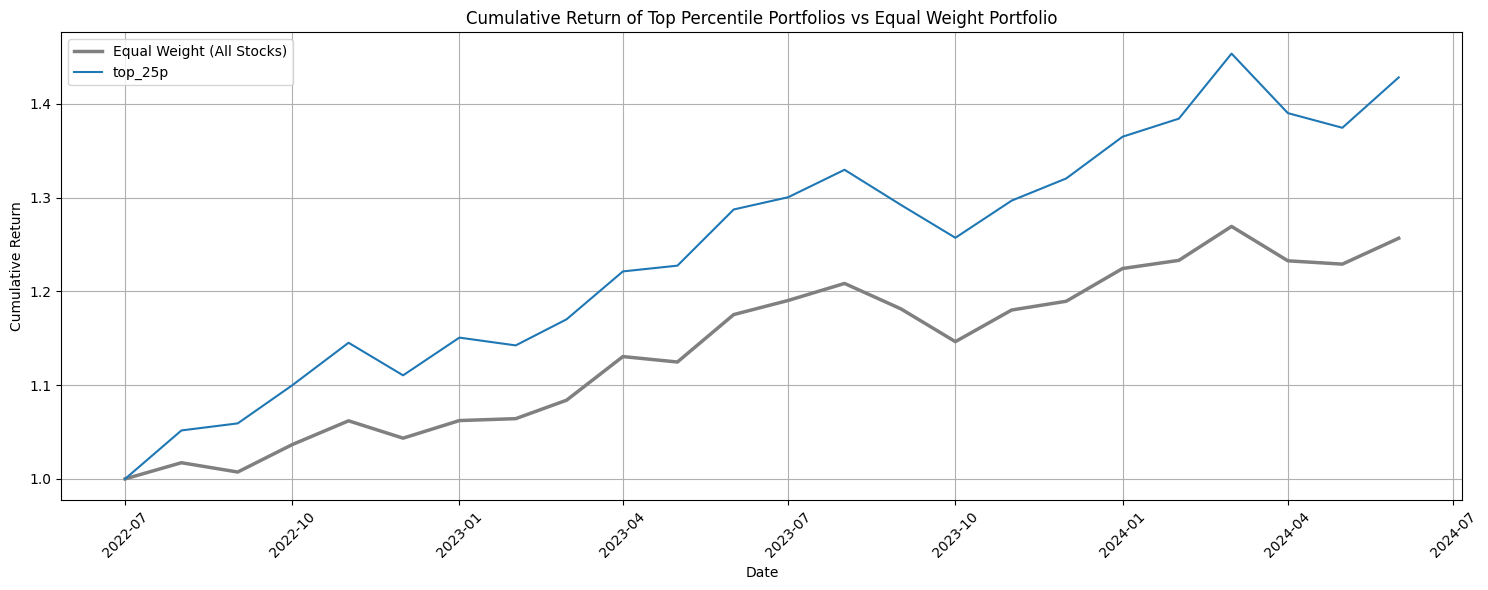

In [78]:
# set date index
multiple_portfolios.index = pd.to_datetime(multiple_portfolios.index)

# 可視化
plot_portfolio_returns(multiple_portfolios)

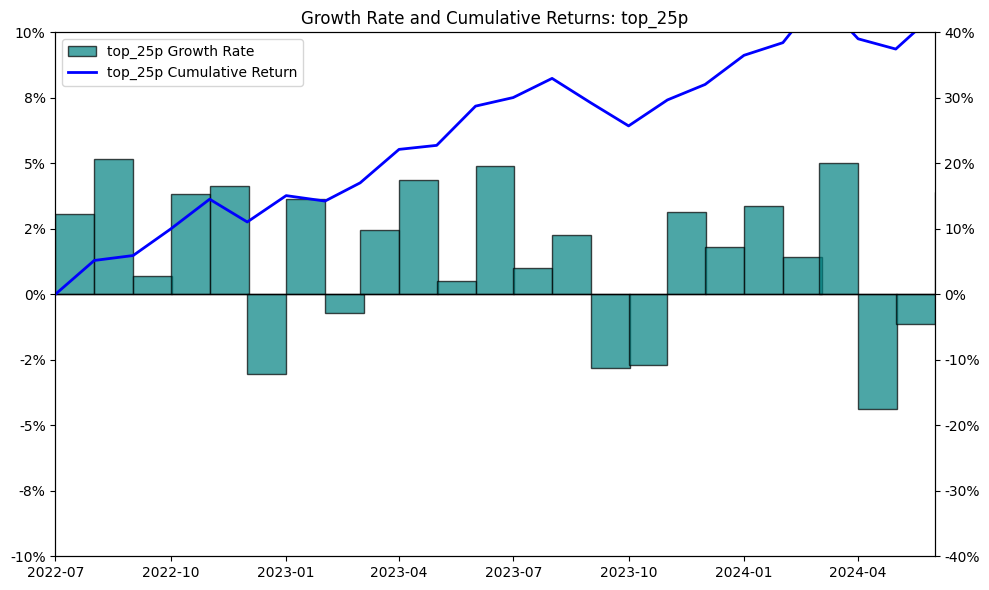

In [79]:
plot_growth_rate(multiple_portfolios, 'top_25p', monthly_return_abs=10, cumulative_return_abs=40)

In [80]:
monthly_tickers = {}

for month, group in df_yoy.groupby('MONTH'):
    # NaNを除外
    group = group.dropna(subset=['TOTAL_SALES'])
    # 上位25%の閾値を計算
    threshold = group['TOTAL_SALES'].quantile(0.75)
    top_25p = group[group['TOTAL_SALES'] >= threshold].copy()
    # 各月のtickerリストを辞書に保存
    monthly_tickers[month] = top_25p['TICKER'].tolist()

# 最大のticker数を取得
max_tickers = max(len(tickers) for tickers in monthly_tickers.values())

# 各月のリストを同じ長さに揃える（空文字を追加）
for month in monthly_tickers:
    current_length = len(monthly_tickers[month])
    if current_length < max_tickers:
        # 不足分を空文字で埋める
        monthly_tickers[month].extend([''] * (max_tickers - current_length))

# データフレームを作成（各月が行、tickerが列）
# まず列名を作成
columns = ['date'] + [f'ticker{i+1}' for i in range(max_tickers)]

# データを準備
data = []
for month in sorted(monthly_tickers.keys()):
    row = [month] + monthly_tickers[month]
    data.append(row)

# データフレームを作成
top_25p_df = pd.DataFrame(data, columns=columns)

# CSVファイルとして保存
top_25p_df.to_csv('../data/top25_tickers.csv', index=False)

In [81]:
# パフォーマンス指標計算
print("パフォーマンス指標を計算中...")
performance_metrics = calculate_performance_metrics(multiple_portfolios)

print("\n=== パフォーマンス指標 ===")
print(performance_metrics.round(2))


パフォーマンス指標を計算中...

=== パフォーマンス指標 ===
          Total Return (%)  Annual Return (%)  Monthly Return (%)  \
top_25p              47.17              21.31                1.66   
top_100p             30.26              14.13                1.13   

          Annual Volatility (%)  Monthly Volatility (%)  Sharpe Ratio  \
top_25p                    9.76                    2.82          2.18   
top_100p                   7.51                    2.17          1.88   

          Max Drawdown (%)  Win Rate (%)  
top_25p              -5.46         75.00  
top_100p             -5.14         70.83  


In [82]:
# 月次統計計算
print("\n=== 月次リターンの詳細統計 ===")
monthly_stats = calculate_monthly_statistics(multiple_portfolios)
print(monthly_stats.round(2))



=== 月次リターンの詳細統計 ===
          月次平均リターン (%)  月次ボラティリティ (%)  最小月次リターン (%)  最大月次リターン (%)  中央値 (%)
top_25p           1.66           2.82         -4.37          5.17     2.34
top_100p          1.13           2.17         -2.96          4.50     1.62


In [83]:
# 最終累積リターン計算
print("\n=== 最終累積リターン ===")
final_returns = calculate_final_returns(multiple_portfolios)
print(final_returns.to_string(index=False))



=== 最終累積リターン ===
Portfolio  Final Return
  top_25p          1.47
 top_100p          1.30


In [84]:
# 分析結果サマリー
generate_analysis_summary(multiple_portfolios, df_yoy, performance_metrics)


=== 分析結果サマリー ===
分析期間: 2022-07-01 00:00:00 から 2024-06-01 00:00:00
対象銘柄数: 238
分析したポートフォリオ: ['top_25p', 'top_100p']

最高パフォーマンス: top_25p (47.17%)
最低パフォーマンス: top_100p (30.26%)

最高シャープレシオ: top_25p (2.18)
最低最大ドローダウン: top_25p (-5.46%)

=== パーセンタイルポートフォリオ間の比較 ===
最高パーセンタイル: top_25p (47.17%)
最低パーセンタイル: top_100p (30.26%)
